In [1]:
%cd /home/jasper/Documents/PhD/Y0/vae_sketch_to_sound/src
!pwd

/home/jasper/Documents/PhD/Y0/vae_sketch_to_sound/src
/home/jasper/Documents/PhD/Y0/vae_sketch_to_sound/src


In [2]:
from benchmark_VAE.src.pythae.models import VQVAE, VQVAEConfig
from benchmark_VAE.src.pythae.models import SVAE, SVAEConfig
from benchmark_VAE.src.pythae.models import DisentangledBetaVAE, DisentangledBetaVAEConfig
from benchmark_VAE.src.pythae.models import VAE, VAEConfig
from benchmark_VAE.src.pythae.models import BetaTCVAE, BetaTCVAEConfig
from benchmark_VAE.src.pythae.trainers import BaseTrainerConfig
from benchmark_VAE.src.pythae.pipelines.training import TrainingPipeline
from benchmark_VAE.src.pythae.models.nn.benchmarks.mnist.resnets import Encoder_ResNet_VQVAE_MNIST, Decoder_ResNet_VQVAE_MNIST

from benchmark_VAE.src.pythae.models.nn.benchmarks.mnist.resnets import Encoder_ResNet_VAE_MNIST, Decoder_ResNet_AE_MNIST


import torch
import torchvision.datasets as datasets

from torchvision.transforms.functional import to_pil_image

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

/home/jasper/miniforge3/envs/s2s/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


In [3]:

model_config = DisentangledBetaVAEConfig(
    input_dim=(1, 64, 64),
    latent_dim=32,
    reconstruction_loss= "mse",
    beta=2.,
    C=30.0,
    warmup_epoch=100

)

model = DisentangledBetaVAE(
    model_config=model_config,
    encoder=Encoder_ResNet_VAE_MNIST(model_config), 
    decoder=Decoder_ResNet_AE_MNIST(model_config) 
).to(device)

In [4]:
model

DisentangledBetaVAE(
  (decoder): Decoder_ResNet_AE_MNIST(
    (layers): ModuleList(
      (0): Linear(in_features=32, out_features=2048, bias=True)
      (1): Sequential(
        (0): ResBlock(
          (conv_block): Sequential(
            (0): ReLU()
            (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (2): ReLU()
            (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
          )
        )
        (1): ResBlock(
          (conv_block): Sequential(
            (0): ReLU()
            (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (2): ReLU()
            (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
          )
        )
        (2): ResBlock(
          (conv_block): Sequential(
            (0): ReLU()
            (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (2): ReLU()
            (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
       

In [10]:
mnist_trainset = datasets.MNIST(root='../../data', train=True, download=True, transform=None)

train_dataset = mnist_trainset.data[:-50000].reshape(-1, 1, 28, 28) / 255.
eval_dataset = mnist_trainset.data[-10000:].reshape(-1, 1, 28, 28) / 255.

In [7]:
train_dataset[:1].shape

torch.Size([1, 1, 28, 28])

In [49]:
embedding = model.encoder(train_dataset[:1]).embedding
embedding.shape

torch.Size([1, 16, 4, 4])

In [50]:
embeddings = embedding.permute(0, 2, 3, 1)
embeddings.shape

torch.Size([1, 4, 4, 16])

In [53]:
z = model.quantizer(embeddings, uses_ddp=False).quantized_vector

In [20]:
img = torch.nn.functional.interpolate(train_dataset[2:5], size=(64,64))
img.shape

torch.Size([3, 1, 64, 64])

In [4]:
from PIL import Image
import numpy as np

torch.Size([1, 1, 64, 64])


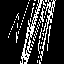

In [5]:
img = np.array(Image.open('../datasets/crop_640/1/00000_614a_d239.png'))
img = torch.from_numpy(img).to(device)
img = 1-img.unsqueeze(0).unsqueeze(0)/255.

img = torch.nn.functional.interpolate(img, size=(64,64))
print(img.shape)
to_pil_image(img[0])

In [6]:
img.max()

tensor(1., device='cuda:0')

In [8]:
%%time
out = model(dict(data=img))

CPU times: user 2.26 ms, sys: 1.29 ms, total: 3.55 ms
Wall time: 3.05 ms


In [10]:
256*16

4096

In [9]:
import torch.nn as nn
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [26]:
a = torch.zeros((2,128,64,64)).to(device)

b = nn.ConvTranspose2d(128, 128, 4, 2, padding=1).to(device)
c = nn.Conv2d(128, 128, 4, 2, padding=1).to(device)

In [27]:
d = c(a)
d.shape

torch.Size([2, 128, 32, 32])

In [8]:
out.keys()

odict_keys(['recon_loss', 'reg_loss', 'loss', 'recon_x', 'z'])

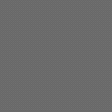

In [13]:
to_pil_image(out.recon_x[0])

In [9]:
out.z

tensor([[-0.0490,  0.2069,  0.1350,  0.0492, -0.1693,  0.0792,  0.0774, -0.0556,
          0.0349,  0.0029, -0.2590,  0.0953, -0.1836,  0.1020,  0.3490,  0.0332,
          0.2473, -0.1583, -0.1192, -0.1606,  0.2858,  0.0873,  0.0491, -0.2933,
         -0.1309, -0.4745,  0.2475,  0.1074, -0.1174, -0.0861,  0.0682, -0.0288]],
       device='cuda:0', grad_fn=<SubBackward0>)

In [15]:
model.encoder

Encoder_ResNet_VQVAE_MNIST(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (3): Sequential(
      (0): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (4): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (5): Sequential(
      (0): ResBlock(
        (conv_block): Sequential(
          (0): ReLU()
          (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): ReLU()
          (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
        )
      )
      (1): ResBlock(
        (conv_block): Sequential(
          (0): ReLU()
          (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1,

## Training

In [5]:
!pwd

/home/jasper/Documents/PhD/Y0/vae_sketch_to_sound/src


In [6]:
my_training_config = BaseTrainerConfig(
    output_dir='/home/jasper/Documents/PhD/Y0/vae_sketch_to_sound/out',
    num_epochs=50000,
    learning_rate=1e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    steps_saving=2000,
    optimizer_cls="AdamW",
    optimizer_params={"weight_decay": 0.05, "betas": (0.91, 0.99)}
)

# my_training_config = BaseTrainerConfig(
#     output_dir='/home/jasper/Documents/PhD/Y0/vae_sketch_to_sound/out',
#     num_epochs=50000,
#     learning_rate=1e-3,
#     per_device_train_batch_size=64,
#     per_device_eval_batch_size=64,
#     # train_dataloader_num_workers=2,
#     # eval_dataloader_num_workers=2,
#     steps_saving=5000,
#     optimizer_cls="AdamW",
#     optimizer_params={"weight_decay": 0.05, "betas": (0.91, 0.995)},
#     scheduler_cls="ReduceLROnPlateau",
#     scheduler_params={"patience": 5, "factor": 0.5}
# )

pipeline = TrainingPipeline(
    training_config=my_training_config,
	model=model
)

In [7]:
from PIL import Image
import os, os.path
import numpy as np
from torchvision.transforms import GaussianBlur

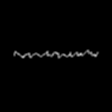

In [120]:
from torchvision.transforms import GaussianBlur

blur = GaussianBlur(3, sigma=1).to(device)
br = blur(img_data_x[:10])

to_pil_image(br[2])

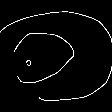

In [118]:
to_pil_image(img_data_x[6])

In [ ]:
from PIL import Image
import os, os.path
import numpy as np

In [8]:
# _Read Images to Array from Folder

imgs = []
labels = []

path = "/home/jasper/Documents/PhD/Y0/vae_sketch_to_sound/datasets/crop_640/1"
path = os.path.join(path,'')

size = 64

valid_images = [".jpg",".gif",".png",".tga"]

# blur = GaussianBlur(3, sigma=1)

for i,f in enumerate(os.listdir(path)):
  ext = os.path.splitext(f)[1]
  filename = os.path.splitext(f)[0]
  if ext.lower() not in valid_images:
      continue
  img = np.array(Image.open(os.path.join(path,f)))
  # print(img.shape)
  img = torch.from_numpy(img)
  img = torch.nn.functional.interpolate(img.unsqueeze(0).unsqueeze(0), size=(size,size), mode='bilinear',antialias=True)
  # img = blur(img)
  
  imgs.append(img[0].numpy())
  # labels.append(int(filename[-2]))

  if i%500==0:
    print(f'processing index {i}')

img_data_x = np.array(imgs)
img_data_y = np.array(labels)
np.random.shuffle(img_data_x)
print(f'collected data {img_data_x.shape}\ncollected label {img_data_y.shape}')

processing index 0
processing index 500
processing index 1000
processing index 1500
processing index 2000
collected data (2217, 1, 64, 64)
collected label (0,)


In [9]:
img_data_x = torch.from_numpy(img_data_x)

img_data_x = 1-img_data_x/255.
# img_data_x = img_data_x.unsqueeze(1)
# img_data_x = img_data_x.permute(0,3,1,2)

# img = torch.nn.functional.interpolate(img_data_x, size=(112,112))

print(img_data_x.shape)
print(img_data_x.max())
print(img_data_x.min())

torch.Size([2217, 1, 64, 64])
tensor(1.)
tensor(0.)


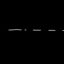

In [10]:
to_pil_image(img_data_x[2])

In [11]:
from torchvision import transforms, datasets
from torchvision.transforms import v2
from torchvision.transforms import InterpolationMode

from torch.utils.data import Dataset

class CustomImageDataset(Dataset):
    def __init__(self, img_data_x):
        self.img_data_x = img_data_x

        self.rf = v2.RandomHorizontalFlip()
        self.rv = v2.RandomVerticalFlip()
        self.rr = v2.RandomRotation(degrees=(0, 180),interpolation=InterpolationMode.BILINEAR)
        self.ra = v2.RandomAffine(degrees=0, translate=(0.4, 0.4))

    def __len__(self):
        return len(self.img_data_x)

    def __getitem__(self, idx):
        x = self.img_data_x[idx]
        x = self.rf(x)
        x = self.rv(x)
        x = self.rr(x)
        x = self.ra(x)
        return dict(data=x)

In [12]:
train_data = CustomImageDataset(img_data_x[:2000])
eval_data = CustomImageDataset(img_data_x[2000:])

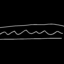

In [14]:
to_pil_image(img_data_x[3])

In [15]:
pipeline(
    train_data=train_data,
    eval_data=eval_data
)

Checking train dataset...
Checking eval dataset...
Using Base Trainer

Model passed sanity check !
Ready for training.

Created /home/jasper/Documents/PhD/Y0/vae_sketch_to_sound/out/DisentangledBetaVAE_training_2023-11-25_14-05-24. 
Training config, checkpoints and final model will be saved here.

Training params:
 - max_epochs: 50000
 - per_device_train_batch_size: 64
 - per_device_eval_batch_size: 64
 - checkpoint saving every: 2000
Optimizer: AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.91, 0.99)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 1e-05
    maximize: False
    weight_decay: 0.05
)
Scheduler: None

Successfully launched training !

Eval of epoch 1/50000: 100%|███████████████████| 4/4 [00:00<00:00, 51.94batch/s]
--------------------------------------------------------------------------
Train loss: 520.308
Eval loss: 517.7737
--------------------------------------------------------------------------
Eva

KeyboardInterrupt: 

In [16]:
%%time
reconstructions = model.reconstruct(img_data_x[:20].to(device)).detach().cpu()
reconstructions.shape

CPU times: user 51.4 ms, sys: 11.8 ms, total: 63.2 ms
Wall time: 61.3 ms


torch.Size([20, 1, 64, 64])

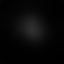

In [29]:
to_pil_image(reconstructions[13])

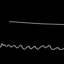

In [35]:
to_pil_image(img_data_x[10])

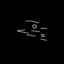

In [37]:
to_pil_image(img_data_x[11])

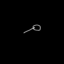

In [52]:
to_pil_image(img_data_x[16])

In [31]:
%%time
out = model(dict(data=img_data_x[:20].to(device)))

CPU times: user 4.57 ms, sys: 12 ms, total: 16.6 ms
Wall time: 15.3 ms


In [45]:
z = out.z.cpu().detach()

In [54]:
np.linalg.norm(z[16] - z[11])

4.7201786

In [3]:
%cd ..

/home/jasper/Documents/PhD/Y0/vae_sketch_to_sound


In [4]:
!rm -r out

## Load

In [38]:
%cd /home/jasper/Documents/PhD/Y0/vae_sketch_to_sound/src
!pwd

/home/jasper/Documents/PhD/Y0/vae_sketch_to_sound/src
/home/jasper/Documents/PhD/Y0/vae_sketch_to_sound/src


In [39]:
%cd /home/jasper/Documents/PhD/Y0/vae_sketch_to_sound/src

# import sys
# import os

# parent_directory = os.path.abspath('..')
# sys.path.append(parent_directory)

from benchmark_VAE.src.pythae.models import AutoModel

/home/jasper/Documents/PhD/Y0/vae_sketch_to_sound/src


In [40]:
import os
from benchmark_VAE.src.pythae.models import AutoModel

import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [41]:
# last_training = sorted(os.listdir('./out/VQVAE_training_2023-10-23_21-16-23/'))[-1]
trained_model = AutoModel.load_from_folder('../out/DisentangledBetaVAE_training_2023-11-23_22-33-39/final_model').to(device)




In [4]:
!pwd
%cd ..

/home/jasper/Documents/PhD/Y0/vae_sketch_to_sound/src/benchmark_VAE
/home/jasper/Documents/PhD/Y0/vae_sketch_to_sound/src


In [5]:
import numpy as np
from torchvision.transforms.functional import to_pil_image
from PIL import Image

In [10]:
from benchmark_VAE.src.pythae.data.datasets import BaseDataset, DatasetOutput
from torchvision.transforms import GaussianBlur
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


torch.Size([1, 1, 112, 112])


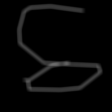

In [25]:
# img = np.array(Image.open('./datasets/crop_640/1/00011_614a_416c.png'))
img = np.array(Image.open('../datasets/2.png').convert("RGB"))[:,:,0]
img = torch.from_numpy(img).to(device)
# img = 1-img.unsqueeze(0).unsqueeze(0)/255.
img = img.unsqueeze(0).unsqueeze(0)/255.



img = torch.nn.functional.interpolate(img, size=(112,112), mode='bilinear',antialias=True)

blur = GaussianBlur(5, sigma=3)
img = blur(img)

print(img.shape)
to_pil_image(img[0])

torch.Size([1, 1, 112, 112])


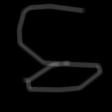

In [26]:
# img = np.array(Image.open('./datasets/crop_640/1/00011_614a_416c.png'))
img = np.array(Image.open('../datasets/2.png').convert("RGB"))[:,:,0]
img = torch.from_numpy(img).to(device)
# img = 1-img.unsqueeze(0).unsqueeze(0)/255.
img = img.unsqueeze(0).unsqueeze(0)/255.



img = torch.nn.functional.interpolate(img, size=(112,112), mode='bilinear',antialias=True)

blur = GaussianBlur(5, sigma=5)
img = blur(img)

print(img.shape)
to_pil_image(img[0])

torch.Size([1, 1, 112, 112])


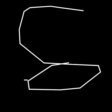

In [14]:
# img = np.array(Image.open('./datasets/crop_640/1/00011_614a_416c.png'))
img = np.array(Image.open('../datasets/2.png').convert("RGB"))[:,:,0]
img = torch.from_numpy(img).to(device)
# img = 1-img.unsqueeze(0).unsqueeze(0)/255.
img = img.unsqueeze(0).unsqueeze(0)/255.



img = torch.nn.functional.interpolate(img, size=(112,112), mode='bilinear',antialias=True)

# blur = GaussianBlur(3, sigma=1)
# img = blur(img)

print(img.shape)
to_pil_image(img[0])

In [46]:
out = trained_model(dict(data=img))

In [47]:
out.keys()

odict_keys(['recon_loss', 'reg_loss', 'loss', 'recon_x', 'z'])

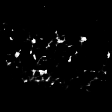

In [48]:
to_pil_image(out.recon_x[0])

In [42]:
img.max()

tensor(0.7259, device='cuda:0')

torch.Size([1, 1, 112, 112])


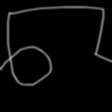

In [29]:
# img = np.array(Image.open('../datasets/crop_640/1/00014_614a_6c3f.png').resize((size,size)))
img = np.array(Image.open('../datasets/crop_640/1/00019_614a_1c43.png').resize((size,size)))
img = torch.from_numpy(img).to(device)
img = 1-img.unsqueeze(0).unsqueeze(0)/255.

img = torch.nn.functional.interpolate(img, size=(112,112), mode='bilinear')

blur = GaussianBlur(3, sigma=1)
img = blur(img)

# img = torch.nn.functional.interpolate(img, size=(112,112))
print(img.shape)
to_pil_image(img[0])

CPU times: user 3.73 ms, sys: 14 µs, total: 3.75 ms
Wall time: 3.21 ms


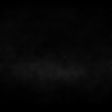

In [32]:
%%time
reconstructions = trained_model.reconstruct(img.to(device)).detach().cpu()
to_pil_image(reconstructions[0])

CPU times: user 1.36 ms, sys: 3.98 ms, total: 5.33 ms
Wall time: 4.52 ms


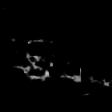

In [23]:
%%time
reconstructions = model.reconstruct(img.to(device)).detach().cpu()
to_pil_image(reconstructions[0])

In [20]:
z = trained_model.embed(img.to(device)).detach().cpu()


In [46]:
z = trained_model.encoder(img.to(device))

In [23]:
z.shape

torch.Size([1, 128])

In [28]:
z_str = z[0].tolist()

In [30]:
len(z_str)

128

In [32]:
z

tensor([[ -4.3195,   0.3602,  -1.6743,  -8.1568,  -3.0431,  -0.6087,  -3.6286,
           7.7889,  -6.0310,  -4.7175,   3.9854,  -7.9331,  -3.3360,   5.1176,
           0.5529,  -6.0310,   5.5030,   0.2637,  -3.1402,  -8.1568, -15.7352,
          -4.2202,   3.1337,   5.5030,  -4.6173,   3.4171,   3.3233,  -9.5880,
           0.3602,   1.3202,  -0.0247,  -2.4535,  -5.1172,   4.7383,   4.2678,
           1.0328,  -0.5114,  -0.8025,   5.1176,  -3.0431,  -4.9182,   0.1670,
          -5.6213,  -7.8218,  -0.0247,  -2.7499,  -1.8674,   0.1670,   1.1280,
         -10.8565,   8.5477,   1.0328,  -4.6173,  -2.0588,  -4.8190,   1.3202,
          -0.6087,  -0.4141,  -9.5880,  -5.4190,   2.9419,   4.2678,  -4.8190,
           5.7937,  -9.3362,  -3.8261,   2.8450,  -3.1402,  -5.7237,  -8.1568,
           0.9383, -10.1184,  -6.1339,  -7.0730,  -2.3550,   2.2762,   3.0375,
           2.8450,  -0.9958,  -7.2844,  -1.2877,  -5.0181,   8.8966,  -0.4141,
           0.4553,   7.2703,  -0.8025,   1.4163,   0

In [31]:
import json
json.dumps(z_str, separators=(',', ':'))

'[-4.319532871246338,0.3602290451526642,-1.6743308305740356,-8.156848907470703,-3.043107748031616,-0.6086670756340027,-3.628629446029663,7.788941383361816,-6.031032085418701,-4.717513084411621,3.98541522026062,-7.9331278800964355,-3.335972785949707,5.117574214935303,0.5528723001480103,-6.031032085418701,5.502973556518555,0.2637450397014618,-3.1402313709259033,-8.156848907470703,-15.735175132751465,-4.220191478729248,3.1337242126464844,5.502973556518555,-4.617330551147461,3.4171180725097656,3.323286533355713,-9.587973594665527,0.3602290451526642,1.3202335834503174,-0.024736313149333,-2.4535439014434814,-5.117249965667725,4.738316535949707,4.267836093902588,1.032843828201294,-0.5113756060600281,-0.8025444746017456,5.117574214935303,-3.043107748031616,-4.9181928634643555,0.16701947152614594,-5.621335983276367,-7.821844100952148,-0.02473631501197815,-2.749936819076538,-1.8673763275146484,0.16701947152614594,1.1280473470687866,-10.85649585723877,8.547654151916504,1.032843828201294,-4.617330

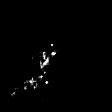

In [30]:
to_pil_image(reconstructions[0])

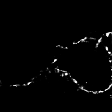

In [27]:
to_pil_image(reconstructions[0])

In [16]:
!pwd

/home/jasper/Documents/PhD/Y0/vae_sketch_to_sound


In [24]:
model

VQVAE(
  (decoder): Decoder_ResNet_VQVAE_CELEBA(
    (layers): ModuleList(
      (0): ConvTranspose2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
      (1): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (2): Sequential(
        (0): ResBlock(
          (conv_block): Sequential(
            (0): ReLU()
            (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (2): ReLU()
            (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
          )
        )
        (1): ResBlock(
          (conv_block): Sequential(
            (0): ReLU()
            (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (2): ReLU()
            (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
          )
        )
      )
      (3): Sequential(
        (0): ConvTranspose2d(128, 128, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
      )
      (4): Sequential(
        (0): ConvTranspose2d(

## Wek

In [37]:
from pythonosc import udp_client

In [40]:
ip="192.168.0.13"
port=6448

In [41]:
client = udp_client.SimpleUDPClient(ip, port)

In [50]:
client.send_message("/wek/inputs", [1.,2.,3.,4.,5.])